In [1]:
import matplotlib
import matplotlib.pyplot as plt
import h5py
import numpy as np
import matplotlib.colors as mcolors
import datetime
import matplotlib.patches as mpatches
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator, FixedLocator)
import os

In [2]:
input_file = '/global/cfs/cdirs/dune/www/data/2x2/nearline_run2/flowed_light/cosmics_bin15/mpd_run_data_rctl_984_p6.FLOW.hdf5'
SAVE = False
pdf_location = './BaselineTest'

In [3]:
## define system constants ##
SAMPLE_RATE = 0.016 # us
BIT = 4  # factor from unused ADC bits on LRS: would be nice to have in a resource .yaml
PRE_NOISE = 50 # Will need to be re-defined once we know beam timing
SAT = 32767
EXPECTED_RATE = 60 # In Hz, obviously depends on subrun conditions
RATE_THD = 20 # Hz over expected trigger rate considered allowable
RANGE = 2000 # ADC range allowed in DQM for baslines
    
sipm_channels = ([4,5,6,7,8,9] + \
                 [10,11,12,13,14,15] + \
                 [20,21,22,23,24,25] + \
                 [26,27,28,29,30,31] + \
                 [36,37,38,39,40,41] + \
                 [42,43,44,45,46,47] + \
                 [52,53,54,55,56,57] + \
                 [58,59,60,61,62,63])

In [4]:
## open file ##
file = h5py.File(input_file, 'r')
size_bytes = os.path.getsize(input_file)
size_gb = size_bytes / (1024 ** 3)
print(f"File size: {size_gb:.2f} GB")

MULT = int(size_gb // 3)
if MULT < 1:
    MULT = 1
print(f"Using MULT = {MULT} for data reduction.")

File size: 2.55 GB
Using MULT = 1 for data reduction.


In [5]:
## To read metadata ##

def visit_func(name, node) :
    if 'ref' in name:
        return
    if [x for x in node.attrs.keys()] != []:
        print ('\nFull object pathname is:', node.name)
    for v in node.attrs.items():
        print(v)
#file.visititems(visit_func)

In [6]:
light_events = file['light/events/data']['id']
print('File shape:', np.shape(light_events))
light_waveforms = file['light/wvfm/data']['samples'][::MULT,:,:,:]

File shape: (4446,)


In [7]:
light_max = np.max(light_waveforms,axis=-1)
light_mdn = np.median(light_waveforms,axis=-1)

In [8]:
def plot_waveform(adc, channel, event_num, wvfm, pdf_output, save_bool=False):
    fig = plt.figure(figsize=(8,3))
    #value = np.abs(wvfm-np.mean(wvfm[:50]))
    plt.plot(wvfm, alpha=0.3, color='blue', rasterized=True)
    #plt.plot(value, alpha=0.3, color='blue', rasterized=True)
    #plt.axhline(np.mean(value[:50]), color='green', linestyle='--', label='Mean [:50]')
    #plt.axhline(np.mean(value), color='red', linestyle='--', label='Mean [Full]')
    plt.title(f"ADC {adc}, Channel {channel}, Event {event_num}: Max Signal Waveform")
    plt.xlabel("Sample [16 ns]")
    plt.ylabel("Raw ADC Counts [16 bit]")
    plt.grid(True)
    #plt.legend()
    plt.tight_layout()
    if save_bool==True:
        pdf_output.savefig(fig)
    plt.close(fig)

In [21]:
def plot_baselines(adc, bsline_arr, pdf_output, save_bool=False, range=2000):
    fig, ax = plt.subplots(figsize=(6,3))
    ax.plot(bsline_arr,marker=".",markerfacecolor='black',markeredgecolor='None',linestyle='None')
    lower_lim = (-28000)-range
    upper_lim = (-28000)+range
    ax.axhline(lower_lim, color='cornflowerblue', linestyle='--', label=f'Range: $\pm${range}', alpha=0.5)
    ax.axhline(upper_lim, color='cornflowerblue', linestyle='--', alpha=0.5)
    ax.xaxis.set_major_locator(MultipleLocator(63))
    ax.xaxis.set_minor_locator(FixedLocator([3.5,9.5,15.5,19.5,25.5,31.5,35.5,41.5,47.5,51.5,57.5]))
    ax.grid(axis = 'x',which="both")
    ax.set_title(f"ADC {adc}: Baseline Distribution")
    ax.set_xlabel("Baseline [ADC Counts]")
    ax.set_ylabel("Channels")
    ax.legend()
    plt.tight_layout()
    if save_bool==True:
        pdf_output.savefig(fig)
    plt.show()
    plt.close(fig)

In [22]:
def plot_signal(adc, signal_arr, pdf_output, save_bool=False):
    fig, ax = plt.subplots(figsize=(6,3))
    ax.plot(signal_arr,marker=".",markerfacecolor='black',markeredgecolor='None',linestyle='None')
    ax.xaxis.set_major_locator(MultipleLocator(63))
    ax.xaxis.set_minor_locator(FixedLocator([3.5,9.5,15.5,19.5,25.5,31.5,35.5,41.5,47.5,51.5,57.5]))
    ax.grid(axis = 'x',which="both")
    ax.set_title(f"ADC {adc}: Max Signal Distribution")
    ax.set_xlabel("Max Signal [ADC Counts]")
    ax.set_ylabel("Channels")
    plt.tight_layout()
    if save_bool==True:
        pdf_output.savefig(fig)
    plt.close(fig)

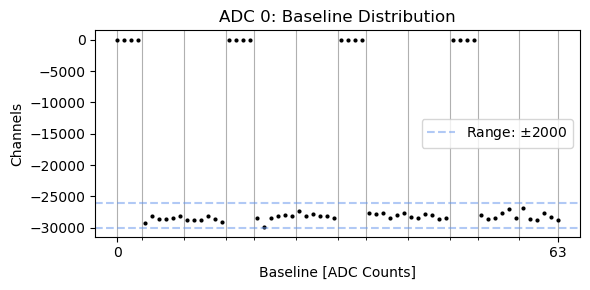

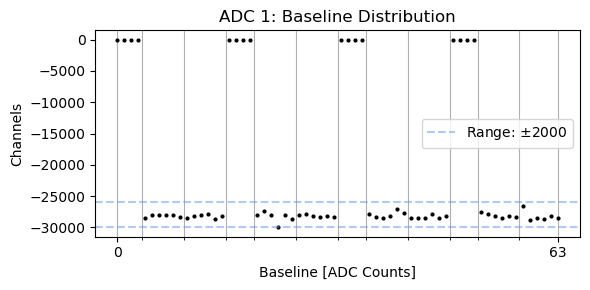

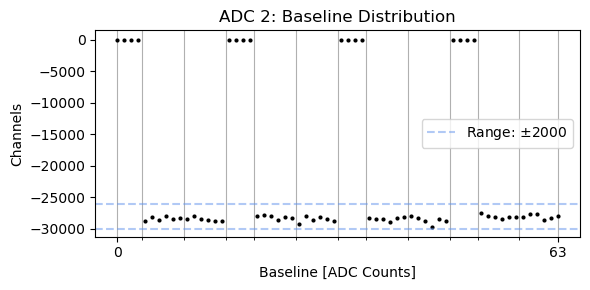

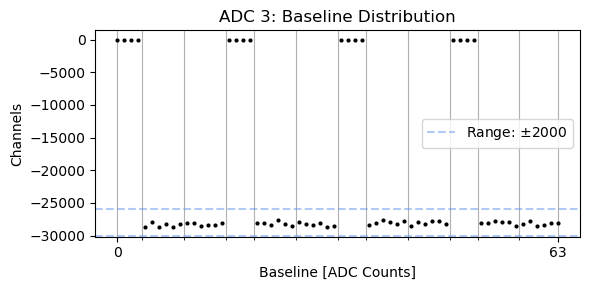

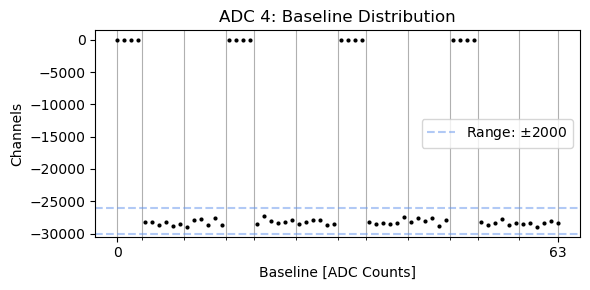

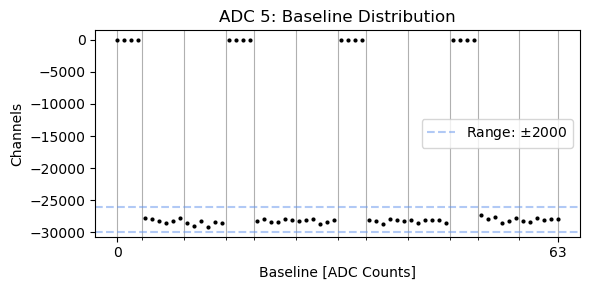

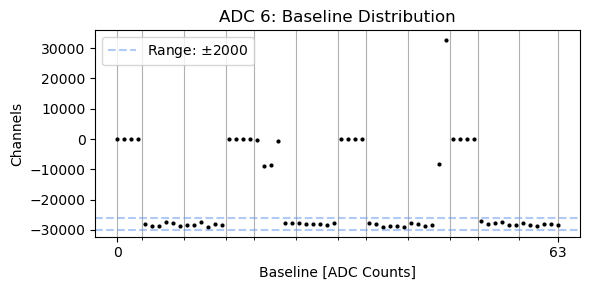

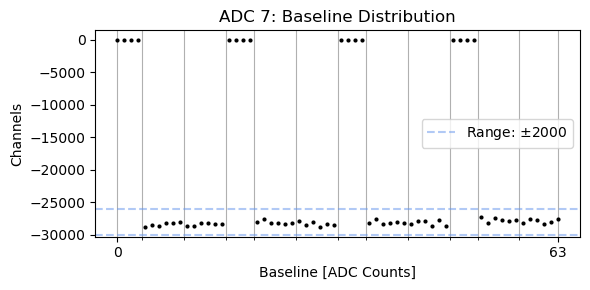

In [23]:
for adc in range(np.shape(light_mdn)[1]):
    if SAVE==True:
        with PdfPages(f"{pdf_location}_{adc}_DarkCount_Baseline.pdf", "w") as pdf:
            median_arr = np.zeros(64)
            ptp_arr = np.zeros(64)
            for channel in range(64):
                median_chan = np.median(light_mdn[:,adc,channel])
                median_arr[channel] += median_chan
                max_event = np.argmax(light_max[:,adc,channel] - median_chan)
                waveform = light_waveforms[max_event, adc, channel, :]
                ptp_chan = np.max(light_max[:,adc,channel] - median_chan)
                ptp_arr[channel] += ptp_chan
                plot_waveform(adc, channel, event_num=max_event, wvfm=waveform, pdf_output=pdf, save_bool=SAVE)
            plot_baselines(adc, bsline_arr=median_arr, pdf_output=pdf, save_bool=SAVE, range=RANGE)
            plot_signal(adc, signal_arr=ptp_arr, pdf_output=pdf, save_bool=SAVE)
    else:
            median_arr = np.zeros(64)
            ptp_arr = np.zeros(64)
            for channel in range(64):
                median_chan = np.median(light_mdn[:,adc,channel])
                median_arr[channel] += median_chan
                max_event = np.argmax(light_max[:,adc,channel] - median_chan)
                waveform = light_waveforms[max_event, adc, channel, :]
                ptp_chan = np.max(light_max[:,adc,channel] - median_chan)
                ptp_arr[channel] += ptp_chan
                plot_waveform(adc, channel, event_num=max_event, wvfm=waveform, pdf_output=None, save_bool=SAVE)
            plot_baselines(adc, bsline_arr=median_arr, pdf_output=None, save_bool=SAVE, range=RANGE)
            plot_signal(adc, signal_arr=ptp_arr, pdf_output=None, save_bool=SAVE)
        